# Dependencias

In [ ]:
#!pip install numpy pandas sentence-transformers scikit-learn matplotlib hdbscan umap-learn wordcloud
!pip install unidecode
!python -m spacy download es_core_news_lg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 3.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
import re
import spacy
import hdbscan
import umap
import es_core_news_lg

# Carga de datos

In [ ]:
dataset = pd.read_csv('dataset.csv', delimiter=',')
dataset.head()

,supermarket,product_code,category,name,price,lastUpdate,subcategory
0,Alcampo,55452,25,Plátano Canario extra bolsa,"2,89",1.742743e+09,estandar
1,Alcampo,59772,25,Banana a granel,"1,48",1.742743e+09,estandar
2,Alcampo,616252,25,ALCAMPO CULTIVAMOS LO BUENO Plátano de Canaria...,"3,99",1.742743e+09,estandar
3,Alcampo,56644,25,Plátano macho para freir a granel,"1,20",1.742743e+09,estandar
4,Alcampo,474889,25,ALCAMPO CULTIVAMOS LO BUENO ECOLÓGICO Plátanos...,"4,29",1.742743e+09,estandar


In [ ]:
print("La información del dataset completo es de (filas,columnas): " + str(dataset.shape))

La información del dataset completo es de (filas,columnas): (36458, 7)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36458 entries, 0 to 36457
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   supermarket   36458 non-null  object 
 1   product_code  36458 non-null  int64  
 2   category      36458 non-null  int64  
 3   name          36458 non-null  object 
 4   price         36458 non-null  object 
 5   lastUpdate    36458 non-null  float64
 6   subcategory   36458 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.9+ MB


#Tipos de datos

In [ ]:
def isBinary(column):
    return column.isin([0, 1]).all()

cols_categorical = 0
binary_columns = [col for col in dataset.columns if isBinary(dataset[col])]
unique_counts = dataset.nunique()
filtered_columns = unique_counts[(unique_counts >= 3) & (unique_counts <= 10)]
filtered_columns_list = filtered_columns.index.tolist()
cols_categorical = len(filtered_columns_list) + len(binary_columns)

cols_categorical_names = set(binary_columns + filtered_columns_list)

print("Hay ",cols_categorical," columnas donde se repiten mas de 5 valores")
print("Las columnas son ",cols_categorical_names)

Hay  2  columnas donde se repiten mas de 5 valores
Las columnas son  {'supermarket', 'subcategory'}


In [ ]:
#se añade product_code como categorico, porque es un identificador númerico, representativo de elementos.
#lastUpdate es una variable de tiempo, no es ni continua ni categoria
#name es una variable de datos no estructurados, es texto.
df_continuous = dataset['price']
df_categorical = dataset[['supermarket', 'category', 'subcategory', 'product_code']]

# Analisis datos (EDA)

## Nulos

In [ ]:
nulosPorColumna = dataset.isnull().sum()

#Mostramos el resultado en una tabla
print("Número de valores nulos por columna:\n" + str(nulosPorColumna))

Número de valores nulos por columna:
supermarket     0
product_code    0
category        0
name            0
price           0
lastUpdate      0
subcategory     0
dtype: int64


##Duplicados

In [ ]:
duplicados = dataset.duplicated()
print(dataset[duplicados])

Empty DataFrame
Columns: [supermarket, product_code, category, name, price, lastUpdate, subcategory]
Index: []


In [ ]:
duplicados = (
    dataset
    .groupby(["supermarket", "name", "price", "product_code"])
    .size()
    .reset_index(name="n_duplicados")
    .query("n_duplicados > 1")
)

In [ ]:
duplicado_dist = (
    duplicados["n_duplicados"]
    .value_counts()
    .sort_index()
    .reset_index()
)

duplicado_dist.columns = ["veces_repetido", "cantidad_grupos"]


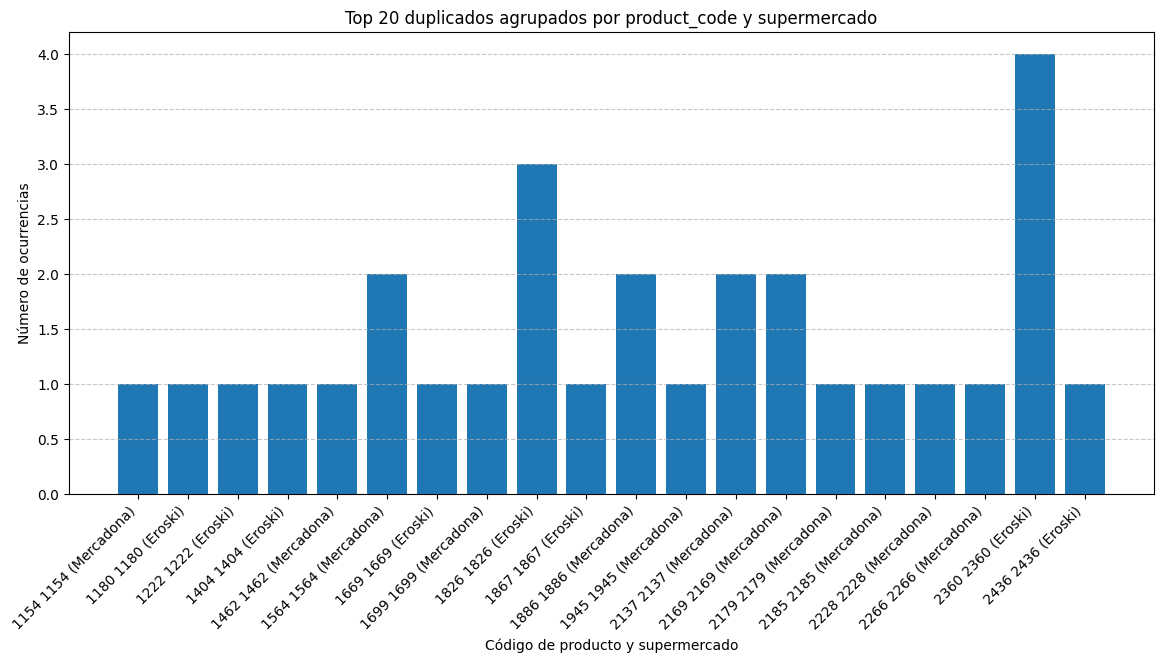

In [ ]:
duplicados_por_codigo = dataset.groupby(['product_code', 'supermarket']).size()
N = 20
top_duplicados = duplicados_por_codigo.head(N)

labels = [f'{code} {code} ({market})' for code, market in top_duplicados.index]

plt.figure(figsize=(14, 6))
plt.bar(labels, top_duplicados.values)
plt.ylabel('Número de ocurrencias')
plt.xlabel('Código de producto y supermercado')
plt.title(f'Top {N} duplicados agrupados por product_code y supermercado')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## Eliminar duplicados

In [ ]:
dataset = dataset.drop_duplicates(subset=["supermarket", "name", "price", "product_code", "subcategory"])

In [ ]:
dataset['price'] = dataset['price'].str.replace(',', '.').astype(float)
dataset['category'] = dataset['category'].astype(int)

<ipython-input-14-4235253802>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['price'] = dataset['price'].str.replace(',', '.').astype(float)
<ipython-input-14-4235253802>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['category'] = dataset['category'].astype(int)


## Distribución de los datos

## Balanceo del dataset

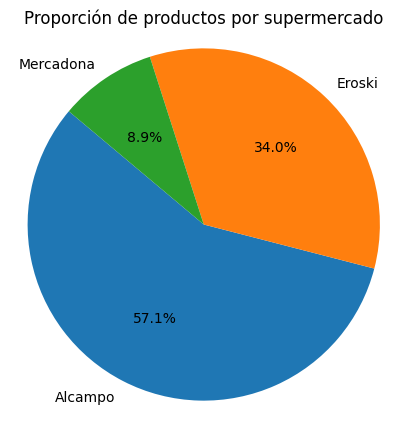

In [ ]:
supermarket_values = dataset['supermarket'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(supermarket_values.values, labels=supermarket_values.index, autopct='%1.1f%%', startangle=140)
plt.title('Proporción de productos por supermercado')
plt.axis('equal')

plt.show()


### Histogramas

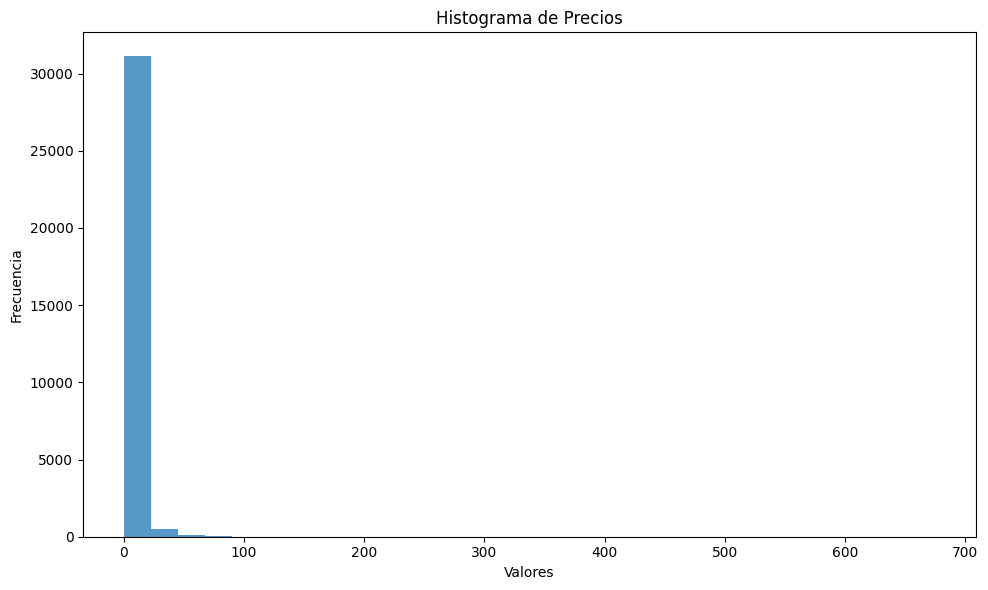

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
dataset['price'].hist(bins=30, grid=False, alpha=0.75)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios')
plt.tight_layout()
plt.show()


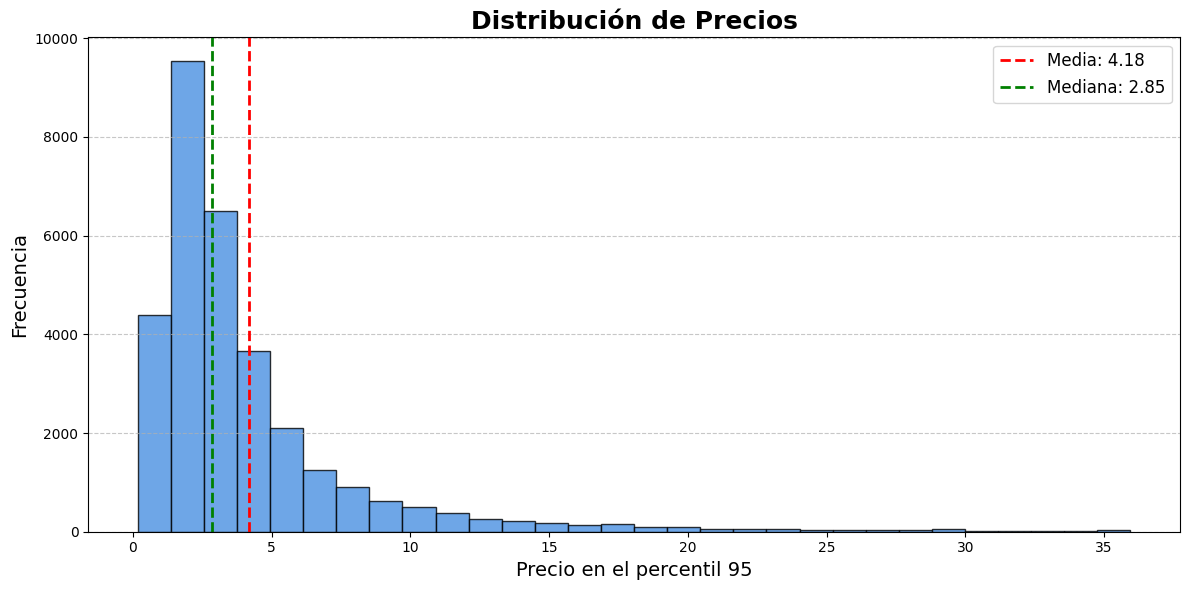

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tus precios están en un array/lista/serie llamado "precios"
# Si usas pandas: precios = df['precio']

# Limita a percentil 95 para evitar outliers extremos
precios = dataset['price']
limite = np.percentile(precios, 99)
precios_filtrados = precios[precios <= limite]

plt.figure(figsize=(12,6))
plt.hist(precios_filtrados, bins=30, color='#4A90E2', edgecolor='black', alpha=0.8)

plt.title('Distribución de Precios', fontsize=18, fontweight='bold')
plt.xlabel('Precio en el percentil 95', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Si quieres mostrar media y mediana:
media = np.mean(precios_filtrados)
mediana = np.median(precios_filtrados)
plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana:.2f}')
plt.legend(fontsize=12)

plt.show()


### boxplot

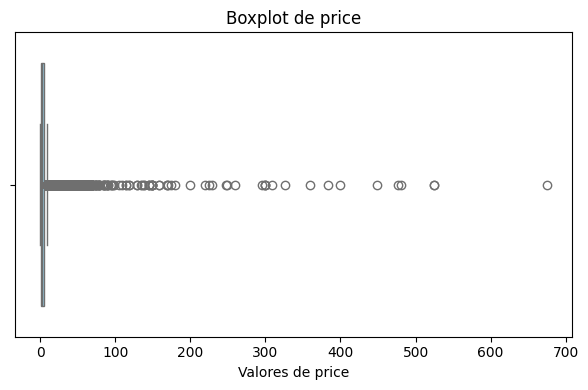

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(6,4))
sb.boxplot(x=dataset['price'], color='skyblue')
plt.title('Boxplot de price')
plt.xlabel('Valores de price')
plt.tight_layout()
plt.show()


## Simetria

In [ ]:
values = dataset['price']
skewness = values.skew()
print("La columna price tiene un coeficiente de asimetría de Fisher-Pearson con valor ",skewness)

La columna price tiene un coeficiente de asimetría de Fisher-Pearson con valor  24.19227780063775


## Datos estadisticos

In [ ]:
dataset['price'].describe()

,price
count,31798.000000
mean,4.949685
std,12.232739
min,0.180000
25%,1.800000
50%,2.890000
75%,4.797500
max,675.000000


## Correlación

### Kruskal-Wallis

In [ ]:
import pandas as pd
from scipy.stats import kruskal

results = []

df_copy = dataset.copy()

for cat_col in dataset.columns:
    niveles = df_copy[cat_col].dropna().unique()
    if len(niveles) < 2:
        continue

    for cont_col in ['price']:

        grupos = [
            df_copy.loc[df_copy[cat_col] == nivel, cont_col].dropna().values
            for nivel in niveles
        ]

        if all(len(g) >= 2 for g in grupos):
            stat, p = kruskal(*grupos)
            results.append({
                "categorica": cat_col,
                "continua": cont_col,
                "statistic": stat,
                "p_value": p
            })

res_df = pd.DataFrame(results)

res_df["significativo (p<0.05)"] = res_df["p_value"] < 0.05

print(res_df.sort_values("p_value").reset_index(drop=True))

    categorica continua    statistic        p_value  significativo (p<0.05)
0     category    price  9366.596941   0.000000e+00                    True
1  supermarket    price   614.108382  4.446920e-134                    True


## Normalización

In [ ]:
scaler = StandardScaler()
dataset["price_norm"] = scaler.fit_transform(dataset[["price"]])

def subcat_to_allergen_flags(subcat):
    subcat = subcat.lower()

    sin_gluten = "celiaco" in subcat or "sin gluten" in subcat
    sin_lactosa = "sin lactosa" in subcat
    sin_soja = "sin soja" in subcat
    vegano = "vegana" in subcat or "vegano" in subcat

    return [
        int(sin_gluten),                 # sin gluten
        int(sin_lactosa or vegano),     # sin lactosa (o por ser vegano)
        int(sin_soja),                  # sin soja solo si se indica
        int(vegano)                     # vegano
    ]


dataset["allergens"] = dataset["subcategory"].apply(subcat_to_allergen_flags)


dataset[["category", "supermarket"]] = dataset[["category", "supermarket"]].fillna("unknown")

encoder_category = OneHotEncoder(sparse_output=False)
category_encoded = encoder_category.fit_transform(dataset[["category"]])
category_columns = encoder_category.get_feature_names_out(["category"])
df_cat_encoded = pd.DataFrame(category_encoded, columns=category_columns, index=dataset.index)

encoder_super = OneHotEncoder(sparse_output=False)
super_encoded = encoder_super.fit_transform(dataset[["supermarket"]])
supermarket_columns = encoder_super.get_feature_names_out(["supermarket"])
df_super_encoded = pd.DataFrame(super_encoded, columns=supermarket_columns, index=dataset.index)

df = pd.concat([dataset, df_cat_encoded, df_super_encoded], axis=1)


In [ ]:
df.head()

,supermarket,product_code,category,name,price,lastUpdate,subcategory,price_norm,allergens,category_1,...,category_34,category_35,category_36,category_37,category_38,category_39,category_40,supermarket_Alcampo,supermarket_Eroski,supermarket_Mercadona
0,Alcampo,55452,25,Plátano Canario extra bolsa,2.89,1.742743e+09,estandar,-0.168377,"[0, 0, 0, 0]",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Alcampo,59772,25,Banana a granel,1.48,1.742743e+09,estandar,-0.283644,"[0, 0, 0, 0]",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Alcampo,616252,25,ALCAMPO CULTIVAMOS LO BUENO Plátano de Canaria...,3.99,1.742743e+09,estandar,-0.078453,"[0, 0, 0, 0]",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Alcampo,56644,25,Plátano macho para freir a granel,1.20,1.742743e+09,estandar,-0.306533,"[0, 0, 0, 0]",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Alcampo,474889,25,ALCAMPO CULTIVAMOS LO BUENO ECOLÓGICO Plátanos...,4.29,1.742743e+09,estandar,-0.053929,"[0, 0, 0, 0]",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Procesamiento del texto

In [ ]:
nlp = spacy.load("es_core_news_lg")

In [ ]:
def extract_volume(text):
    patterns = [
        (r"(\d+[,.]?\d*)\s*(l|litros?|lts?)\b", 1000),
        (r"(\d+[,.]?\d*)\s*(ml|mililitros?|cc)\b", 1),
        (r"(\d+[,.]?\d*)\s*cl\b", 10),
    ]
    for pattern, multiplier in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            value = float(match.group(1).replace(',', '.'))
            return value * multiplier
    return None


In [ ]:
def extract_weight(text):
    patterns = [
        # Ejemplos: "500g", "0.5kg", "1.2 kg", "750 gr"
        (r"(\d+[,.]?\d*)\s*(kg|kilogramos?|kilos?)\b", 1000),
        (r"(\d+[,.]?\d*)\s*(g|gr|gramos?)\b", 1)
    ]

    for pattern, multiplier in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            value = float(match.group(1).replace(',', '.'))
            return value * multiplier
    return None

In [ ]:
def normaliza_unidad(unidad):
    if unidad is None:
        return None
    u = unidad.lower().replace('.', '').strip()
    return unidades_map.get(u, u)

In [ ]:
extra_stopwords = {
    "alcampo", "mercadona", "eroski", "extra", "bolsa", "peso", "aproximado", "envase",
    "bote", "tarro", "a granel", "bandeja", "lata", "botella", "maduro", "madura", "producto"
}

protected_brands = {
    "tarradellas", "hacendado", "coca-cola", "barceló", "amstel",
    "heineken", "danone", "gullón", "gullon", "nestlé", "orígens",
    "origens", "beefeater", "pescanova", "selecciona",
    "auchan", "bueno", "gallo", "nestlé", "kaiku","carretilla",
    "campofrío", "oetker", "helios", "el pozo", "lindt", "frit ravich",
    "milka", "pedro luis", "don simon", "calvo","gourmet", "igp",
    "findus", "albo", "puleva", "ducros", "haribo", "la lechera",
    "gallina blanca", "central lechera asturiana", "ybarra", "carmencita",
    "granini", "pascual", "borges", "juver", "luengo", "casa tarradellas",
    "cocinera", "royal", "navidul", "coren", "dulcesol", "miguelañez",
    "kellogg", "old el paso", "tulipán", "prima", "príncipe", "mercader",
    "musa", "pompadour", "amatista", "gvtarra", "martini", "artiach",
    "viña albali", "mahou", "marqués", "freixenet","cune", "codorniu",
    "casera", "font vella", "fanta", "monster", "aquarius","kas", "coto",
    "estrella galicia", "yosoy", "cruzcampo", "castillo", "alpro", "bach",
    "top lider", "bezolla", "maggi", "serpis", "delfín","harimsa", "yatekomo",
    "argal", "sal costa", "el tigre", "litoral", "palacios", "maxifoods", "cornetto",
    "la asturiana","la española","dolce gusto", "la cocinera"
}

# Términos protegidos que no deben eliminarse
protected_keywords = {
    "ron", "margarita", "pizza", "platano", "vino", "boqueron", "g", "kg", "ml", "l", "cl", "unidad", "unidades", "pack"
}

words_map = {
    r"(\d+)[ ]?(gr|gramos?|g\.?)\b": r"\1g",
    r"(\d+)[ ]?(kg|kilos?|kg\.?)\b": r"\1kg",
    r"(\d+)[ ]?(ml|mililitros?|cc)\b": r"\1ml",
    r"(\d+)[ ]?(l|litros?|lt|lts)\b": r"\1l",
    r"(\d+)[ ]?cl\b": r"\1cl",
    r"\b(plátanos?|bananas?)\b": "platano",
    r"\b(de comercio justo|maduros?|CULTIVAMOS LO BUENO|IGP|Indicación Geográfica Protegida)\b": "",
    r"\b(ecológicas?|bio|organic)\b": "ecologico",
    r"\b(pz|ud|uds)\b": "unidad",                       # "ud", "uds", "pz" → "unidad"
    r"\bx[\s\-]?(\d+)\b": r"\1 unidades",               # "x6", "x 12", "x-4" → "6 unidades", "12 unidades", "4 unidades"
    r"\b(\d+)\s*(uds?|unidades?)\b": r"\1 unidades",    # "6 uds", "6 unidades" → "6 unidades"
    r"\b(\d+)\s*pack\b": r"\1 pack",
    r"\bgarbanzo cocido\b": "garbanzo",
    r"\balubia roja\b": "alubia",
    r"\blentejas pardinas\b": "lenteja",
    r"\bplátanir\b": "platano",
    r"\bcervezas\b": "cerveza",
    r"\b\d+[,.]\d+%?\b": "",
    r"\b(a granel|bandeja|malla|barqueta)\b": "",
    r"(\d+)\s*(gr?|gramos?)(\b|$)": r"\1g",
    r"\bpara freir\b": "fritura",
    r"\bde zumo\b": "zumo",
}

unidades_map = {
    "gr": "g",
    "gramo": "g",
    "gramos": "g",
    "kg": "kg",
    "kilo": "kg",
    "kilos": "kg",
    "ml": "ml",
    "mililitros": "ml",
    "l": "l",
    "litro": "l",
    "litros": "l",
    "cl": "cl",
    "cc": "ml",
    "g.": "g",
    "kg.": "kg",
    "lt": "l",
    "lts": "l",
}


In [ ]:
import unicodedata

def normalize(text):
    return unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8").lower()

In [ ]:
def preprocess_text(text):
    text_cleaned = re.sub(r"\(.*?\)", "", text)
    text_cleaned = re.sub(r"[^a-zA-Z0-9áéíóúñÁÉÍÓÚÑ\s]", "", text_cleaned)
    text_cleaned = text_cleaned.lower()

    for pattern, replacement in words_map.items():
        text_cleaned = re.sub(pattern, replacement, text_cleaned, flags=re.IGNORECASE)

    doc = nlp(text_cleaned)

    tokens = []
    protected_spans = set()
    norm_protected_brands = {normalize(b) for b in protected_brands}
    norm_protected_keywords = {normalize(k) for k in protected_keywords}

    for ent in doc.ents:
        if ent.label_ in {"ORG", "PRODUCT", "PER"}:
            for token in ent:
                protected_spans.add(token.i)

    for i, token in enumerate(doc):
        text_token = token.text.lower()
        lemma_token = token.lemma_.lower()
        text_norm = normalize(text_token)
        lemma_norm = normalize(lemma_token)

        # Si es marca dentro de entidad reconocida
        if i in protected_spans:
            ent = next((e for e in doc.ents if e.start <= i < e.end), None)
            if ent and normalize(ent.text) in norm_protected_brands:
                tokens.append(ent.text)
                continue

        # Si es marca directamente
        if text_norm in norm_protected_brands or lemma_norm in norm_protected_brands:
            tokens.append(token.text)
            continue

        # Si es palabra protegida genérica
        if text_norm in norm_protected_keywords or lemma_norm in norm_protected_keywords:
            tokens.append(text_token)
            continue

        # Si es irrelevante
        if (
            token.is_stop or
            text_token in extra_stopwords or
            lemma_token in extra_stopwords or
            token.is_punct or
            (len(text_token) < 2 and text_token not in protected_keywords)
        ):
            continue

        # Si es número
        if token.like_num:
            tokens.append(text_token)
            continue

        # Si es sustantivo/adjetivo útil
        if token.pos_ in ["NOUN", "ADJ", "PROPN"] and lemma_token not in {"granel", "pack"}:
            tokens.append(lemma_token)

    # --- Fallback mejorado: sólo añade marca si NO está en tokens ---
    text_norm = normalize(text)
    for brand in protected_brands:
        brand_norm = normalize(brand)
        already_in_tokens = any(
            (brand_norm == normalize(t) or brand.upper() == t) for t in tokens
        )
        if brand_norm in text_norm and not already_in_tokens:
            tokens.insert(0, brand.upper())

    def deduplicate_brands(tokens):
        seen = set()
        result = []
        for t in tokens:
            if t.isupper() and t not in seen:
                seen.add(t)
                result.append(t)
            elif not t.isupper():
                result.append(t)
        return result

    tokens = deduplicate_brands(tokens)
    tokens = list(dict.fromkeys(tokens))  # deduplicación general

    clean_text = " ".join(tokens)
    clean_text = re.sub(r"\s+", " ", clean_text).strip()

    return clean_text if len(clean_text.split()) > 1 else text_cleaned.strip()


### Limpieza acentos

In [ ]:
from unidecode import unidecode

def cleanUnicode(original_text):
  texto_limpio = unidecode(original_text)
  return texto_limpio

In [ ]:
df['volume_ml'] = df['name'].apply(extract_volume)
df['weight_g'] = df['name'].apply(extract_weight)
#df['name_clean'] = df['name'].apply(remove_units)
df['name_clean'] = df['name'].apply(cleanUnicode)
df['name_clean'] = df['name_clean'].apply(preprocess_text)
df['weight_g'] = df.groupby(['category', 'subcategory'])['weight_g'].transform(
    lambda x: x.fillna(x.median())
)

In [ ]:
sample = df.sample(5)[['name', 'name_clean']]
print(sample.to_markdown(index=False))

| name                                                                       | name_clean                                          |
|:---------------------------------------------------------------------------|:----------------------------------------------------|
| RANA Salsa fresca a la carbonara RANA 180 g.                               | rana salsa fresco carbonara 180 g                   |
| Ajo troceado FINDUS, caja 70 g                                             | ajo troceado findus caja 70 g                       |
| FRIT RAVICH Snack de cortezas de trigo FRIT RAVICH BOCAFRIT bolsa de 65 g. | frit ravich corteza trigo frit ravich bocafrit 65 g |
| Jamón curado reducido en sal NAVIDUL, lonchas 45 g                         | jamon curado reducido sal navidul loncha 45 g       |
| Pepinillos agridulces a la miel VEGOLA, frasco 345 g                       | pepinillo agridulz miel vegola frasco 345 g         |


# EDA post-procesamiento

### Frecuencia de palabras en nombres procesado

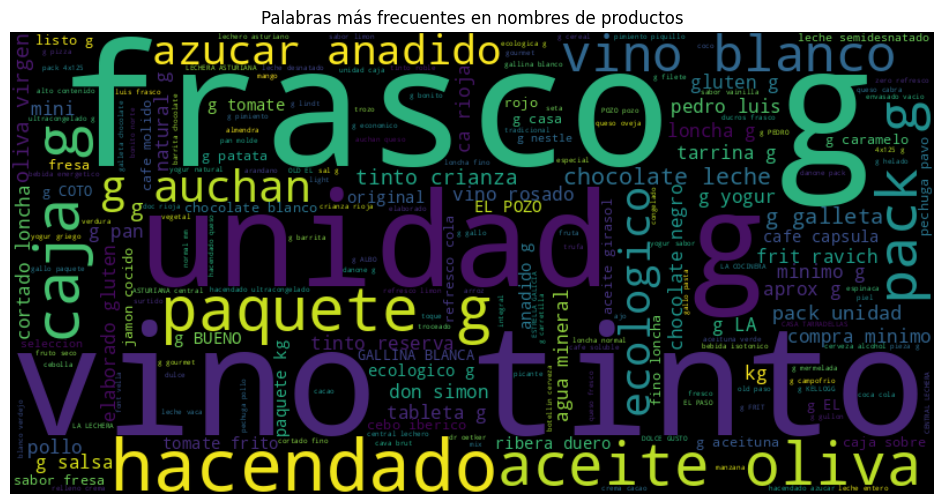

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400).generate(" ".join(df['name_clean']))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Palabras más frecuentes en nombres de productos")
plt.show()

In [ ]:
nulosPorColumna = df.isnull().sum()

print("Número de valores nulos por columna:\n" + str(nulosPorColumna))

Número de valores nulos por columna:
supermarket                  0
product_code                 0
category                     0
name                         0
price                        0
lastUpdate                   0
subcategory                  0
price_norm                   0
allergens                    0
category_1                   0
category_2                   0
category_3                   0
category_4                   0
category_5                   0
category_6                   0
category_7                   0
category_8                   0
category_9                   0
category_10                  0
category_11                  0
category_12                  0
category_13                  0
category_14                  0
category_15                  0
category_16                  0
category_17                  0
category_18                  0
category_19                  0
category_20                  0
category_21                  0
category_22                  0
ca

# Generación embeddings SBERT

In [ ]:
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, models

sbert_model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import pickle

class sBertWrapper:
    def __init__(self, model):
        self.model = model

    def encode(self, text):
        text_embed = self.model.encode(text)
        return text_embed

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)


In [ ]:
wrapper = sBertWrapper(sbert_model)
wrapper.save('sbert_entrenado.pkl')

In [ ]:
def get_embedding(text):
    text_embed = sbert_model.encode(text)
    return text_embed

def get_enriched_embedding(row):
    text = row['name_clean'].lower()
    text_embed = get_embedding(text)

    cat_vec = np.array([row[col] for col in category_columns], dtype=np.float32)
    sup_vec = np.array([row[col] for col in supermarket_columns], dtype=np.float32)
    allergen_vec = np.array(row["allergens"], dtype=np.float32)
    price = np.array([row["price_norm"]], dtype=np.float32)

    enriched = np.concatenate([text_embed, price, cat_vec, sup_vec, allergen_vec])
    return enriched

In [ ]:
df["embedding"] = df.apply(get_enriched_embedding, axis=1)

print("Shape de los embeddings:", df['embedding'].shape)


Shape de los embeddings: (31798,)


In [ ]:
embeddings = np.vstack(df["embedding"].values)
np.save("embeddings.npy", embeddings)

product_ids = df.index.values
np.save("product_ids.npy", product_ids)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#calcular similitud entre el primer y segundo producto
embedding1 = df.loc[0, 'embedding']
embedding2 = df.loc[1, 'embedding']
similarity = cosine_similarity([embedding1], [embedding2])
print("Similitud coseno:", similarity[0][0])

Similitud coseno: 0.92626107


In [ ]:
embedding_matrix = np.vstack(df['embedding'].values)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_top_k_neighbors(index, k=5):
    # Calcula la similitud coseno entre el embedding del producto y todos los demás.
    sim = cosine_similarity([embedding_matrix[index]], embedding_matrix)[0]
    # Ordena los índices (excluyendo el mismo producto)
    sorted_indices = np.argsort(sim)[::-1]
    # Omitir el primero (el propio producto) y devolver los siguientes k
    return sorted_indices[1:k+1], sim[sorted_indices[1:k+1]]

neighbors_idx, sim_values = get_top_k_neighbors(0, k=5)
print("Índices vecinos:", neighbors_idx)
print("Similitudes:", sim_values)
print("Producto base:", df.loc[0, 'name_clean'])
print("Productos vecinos:")
for idx in neighbors_idx:
    print(df.loc[idx, 'name_clean'])

Índices vecinos: [ 5 13  9 12  1]
Similitudes: [0.9997282  0.9986667  0.9526957  0.93969834 0.92626107]
Producto base: platano canario
Productos vecinos:
platano canario
platano canario
platanos canarias
platano macho
platano


# UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


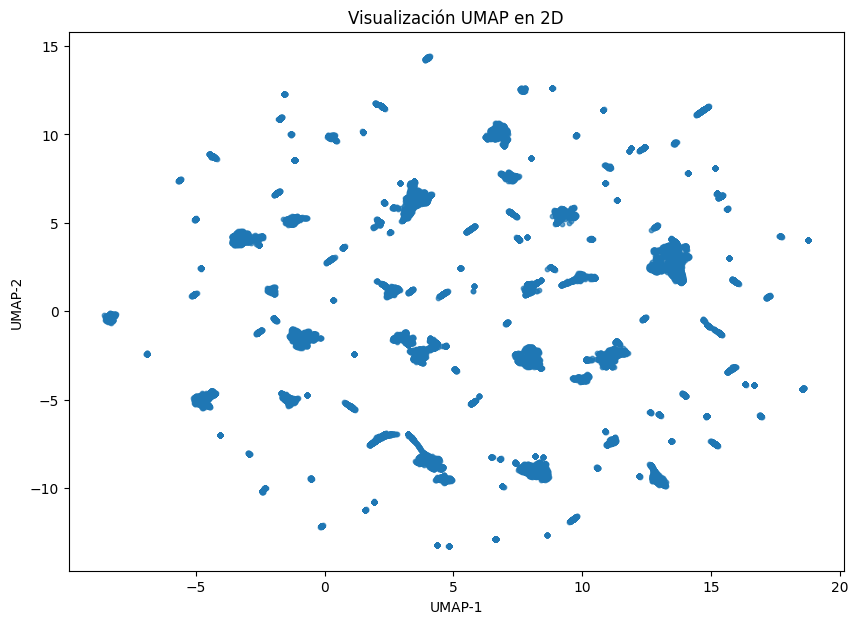

In [ ]:
import umap

reducer = umap.UMAP(
    n_neighbors=50,
    n_components=3,
    metric='cosine',
    min_dist=0.1,
    random_state=42
)
X = reducer.fit_transform(embedding_matrix)  # shape = (N, 2)


plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.7)
plt.title("Visualización UMAP en 2D")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

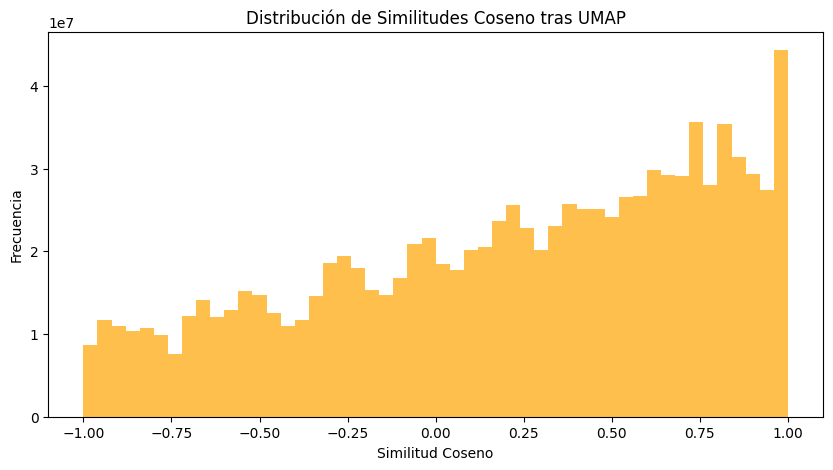

In [ ]:
cos_sim_matrix = cosine_similarity(X)

mask = ~np.eye(cos_sim_matrix.shape[0], dtype=bool)
sim_values = cos_sim_matrix[mask]

plt.figure(figsize=(10, 5))
plt.hist(sim_values, bins=50, alpha=0.7, color='orange')
plt.title("Distribución de Similitudes Coseno tras UMAP")
plt.xlabel("Similitud Coseno")
plt.ylabel("Frecuencia")
plt.show()

# Entrenar modelo con HDBSCAN

In [ ]:
clusterer = hdbscan.HDBSCAN(
    metric='euclidean',         # sobre espacio reducido
    min_cluster_size=25,        # ajusta según tamaño esperado de clúster
    min_samples=8,              # ajusta para controlar ruido
    cluster_selection_method='eom'
)
df['cluster'] = clusterer.fit_predict(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Metricas del modelo

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

mask = df['cluster'] != -1
if np.sum(mask) > 1:
    sil_score = silhouette_score(X[mask], df.loc[mask, 'cluster'])
    db_score = davies_bouldin_score(X[mask], df.loc[mask, 'cluster'])
    ch_score = calinski_harabasz_score(X[mask], df.loc[mask, 'cluster'])
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin: {db_score:.4f}")
    print(f"Calinski-Harabasz: {ch_score:.4f}")
else:
    print("No hay suficientes puntos agrupados para evaluar métricas.")

Silhouette Score: 0.7268
Davies-Bouldin: 0.3444
Calinski-Harabasz: 125785.6406


## Análisis de errores y ruido

In [ ]:
noise = df[df['cluster'] == -1]
print(f"{len(noise)} productos considerados como ruido.")
noise[['name', 'name_clean', 'price', 'category', 'subcategory']].head(10)

2172 productos considerados como ruido.


,name,name_clean,price,category,subcategory
223,PRODUCTO ALCAMPO Bebida de arándano rojo PRODU...,bebida arandano rojo,2.18,32,estandar
246,DON SIMON Bebida de leche y zumo de frutas tro...,don simon bebida leche zumo fruta tropical mat...,1.43,32,estandar
253,BIFRUTAS Leche con zumo de frutas del pacífico...,bifruta leche zumo fruta pacifico materia gras...,2.39,32,estandar
282,DON SIMON Brick zumo de naranja DON SIMÓN 6 ud...,DON SIMON don simon brick zumo naranja unidad,2.18,32,estandar
296,GRANINI Bebida de naranja y zanahoria GRANINI ...,granini bebida naranja zanahoria clasico,3.47,32,estandar
301,"GRANINI Zumo de naranaja 100 % ecológico, sin ...",granini zumo naranaja 100 ecologico aditivo,4.44,32,estandar
305,LIBBY'S Néctar de naranja y papaya LIBBY'S bri...,naranja papaya libbys brick,1.15,32,estandar
311,DON SIMON Néctar sin azúcar añadido tropical D...,don simon azucar anadido tropical don simon di...,1.65,32,estandar
313,DON SIMON Néctar sin azúcar añadido de manzana...,don simon azucar anadido manzana don simon dis...,1.95,32,estandar
335,GRANINI Bebida de melocotón GRANINI Clásico 1 l.,COTO granini bebida melocoton clasico,2.46,32,estandar


In [ ]:
columns_to_save = [
    'supermarket',
    'product_code',
    'category',
    'name',
    'price',
    'lastUpdate',
    'subcategory',
    'allergens',
    'cluster',
    'embedding'
]

df_filtrado = df[columns_to_save]

df_filtrado.to_csv('productos_procesados.csv', index=False)

df_filtrado.to_csv('productos_procesados.csv', index=True)

#Grafo

In [ ]:
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

def build_graphs_by_cluster(df, k_neighbors=20):
    """
    Construye grafos indexados por int(product_code),
    asegurando que G.nodes keys sean ints iguales a shopping_ids.
    """
    graphs_by_cluster = {}
    for cluster_id in df['cluster'].unique():
        subset = df[df['cluster'] == cluster_id].copy()
        if subset.empty:
            continue

        # Asegurar que product_code es un integer
        subset['product_code'] = pd.to_numeric(subset['product_code'], errors='coerce').astype(int)
        codes = subset['product_code'].tolist()

        # Embeddings matrix
        emb_matrix = np.vstack(subset['embedding'].values)

        # Vecinos semánticos
        neighbors_dict = {}
        if len(codes) <= k_neighbors:
            for code in codes:
                neighbors_dict[code] = [c for c in codes if c != code]
        else:
            nn = NearestNeighbors(n_neighbors=k_neighbors+1, metric='cosine', n_jobs=-1)
            nn.fit(emb_matrix)
            distances, indices = nn.kneighbors(emb_matrix)
            for i, code in enumerate(codes):
                neigh_codes = [codes[j] for j in indices[i][1:]]
                neighbors_dict[code] = neigh_codes

        # Crea el grafo con nodos = int(product_code)
        G = nx.Graph()
        for _, row in subset.iterrows():
            code = int(row['product_code'])
            G.add_node(
                code,
                price=float(row['price']),
                allergens=list(row['allergens']),
                embedding=np.array(row['embedding'], dtype=np.float32),
                name=row['name']
            )

        # Añade aristas con peso = distancia semántica
        for code, neighs in neighbors_dict.items():
            for nbr in neighs:
                emb1 = G.nodes[code]['embedding'].reshape(1, -1)
                emb2 = G.nodes[nbr]['embedding'].reshape(1, -1)
                dist = float(cosine_distances(emb1, emb2)[0,0])
                G.add_edge(code, nbr, weight=dist)

        graphs_by_cluster[cluster_id] = G

    return graphs_by_cluster

def build_neighbors_dict(graphs_by_cluster):
    nd = {}
    for G in graphs_by_cluster.values():
        for code in G.nodes:
            nd[code] = list(G.neighbors(code))
    return nd


graphs_by_cluster = build_graphs_by_cluster(df, k_neighbors=10)
neighbors_dict = build_neighbors_dict(graphs_by_cluster)

In [ ]:
import pickle

with open("graphs.pkl", "wb") as f:
    pickle.dump(graphs_by_cluster, f)

In [ ]:
import pickle

with open('neighbors_dict.pkl', 'wb') as f:
    pickle.dump(neighbors_dict, f)

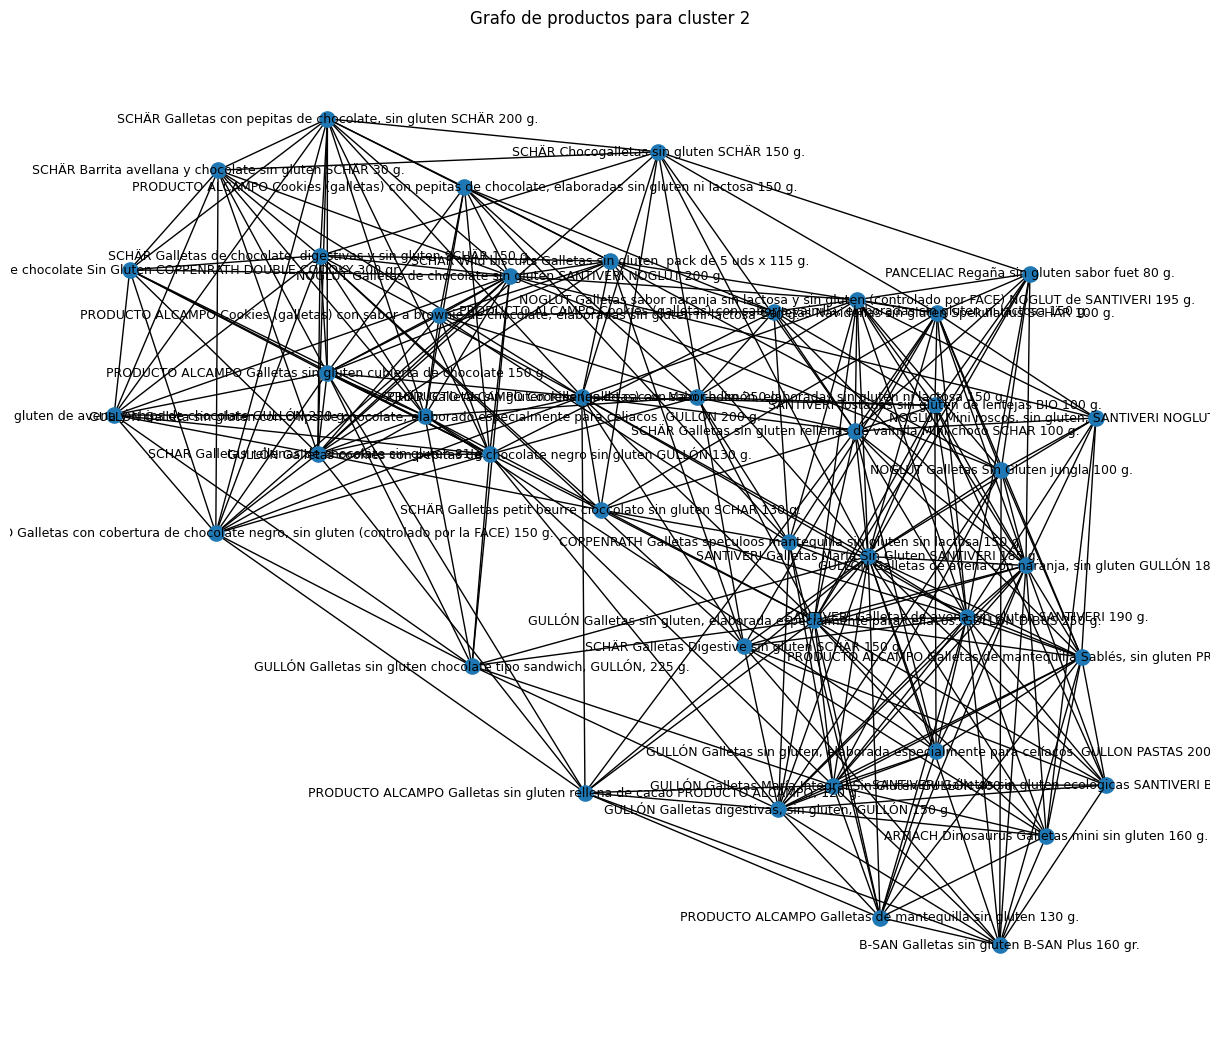

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

cluster_id = 2
G = graphs_by_cluster[cluster_id]

labels = {n: G.nodes[n]['name'] for n in G.nodes}

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    node_size=120,
    with_labels=True,
    labels=labels,
    font_size=9
)
plt.title(f"Grafo de productos para cluster {cluster_id}")
plt.show()



In [ ]:
print(len(graphs_by_cluster))

218
